# 主機異常預警（兩個月 POC）— Colab Demo Notebook
以 ELK Logs 建立「前兆預警」與量化評估（Precision/Recall/F1/平均提前時間）。預設 DEMO（合成資料），亦支援 LIVE_ES（連線 ES）與 UPLOAD（上傳 CSV）。


## 導覽
1. 安裝套件  
2. 選擇模式（DEMO / LIVE_ES / UPLOAD）  
3. 資料取得：合成 / 連線 ES / 上傳 CSV  
4. 評估與四個 CSV 匯出  
5. 圖表（時間熱度 / 噪音設備 / 高價值設備）  
6. 一頁成效摘要（Word/Markdown）  
7. 面試用口頭報告重點


## 1) 安裝套件


In [1]:
!pip -q install pandas requests python-docx matplotlib


## 2) 選擇模式


In [2]:
DEMO_MODE   = True   # 預設 True：合成資料快速跑
LIVE_ES     = False  # 若要連公司 ES 請改 True
UPLOAD_MODE = False  # 若要上傳四個 CSV 請改 True

assert sum([DEMO_MODE, LIVE_ES, UPLOAD_MODE]) == 1, "請只開啟一種模式"


In [3]:
import pandas as pd, numpy as np
from datetime import datetime, timedelta, timezone
from pathlib import Path
import matplotlib.pyplot as plt
plt.rcParams.update({"figure.figsize": (8,4)})


## 3A) DEMO：合成資料（預設）


In [4]:
if DEMO_MODE:
    rng = np.random.default_rng(42)
    start = datetime(2025,9,24,16,0,tzinfo=timezone.utc)
    end   = datetime(2025,10,8,16,0,tzinfo=timezone.utc)
    eqps  = ["a3cim1","khbosvs03","khcrddmzvs01","khaicomp01","khtcimrpaap08"]
    rows_pred = []
    t = start
    while t <= end:
        for e in eqps:
            if rng.random()<0.35 or e=="a3cim1":
                cnt = int(rng.integers(4,10))
                rows_pred.append({"EqpName":e,"t_pred":t+timedelta(minutes=15),"count":cnt,"EqpName_raw":e.upper()})
        t += timedelta(days=1)
    pred = pd.DataFrame(rows_pred)

    rows_lab = []
    for _, r in pred.iterrows():
        if r["EqpName"]=="a3cim1" and rng.random()<0.7:
            rows_lab.append({"EqpName":r["EqpName"], "t_event": r["t_pred"]+timedelta(minutes=int(rng.integers(5,40))), "cnt":1, "EqpName_raw":r["EqpName"].upper()})
        elif rng.random()<0.25:
            rows_lab.append({"EqpName":r["EqpName"], "t_event": r["t_pred"]+timedelta(minutes=int(rng.integers(10,50))), "cnt":1, "EqpName_raw":r["EqpName"].upper()})
    label = pd.DataFrame(rows_lab)

    pred.to_csv("R1_eval_predictions.csv", index=False, encoding="utf-8-sig")
    label.to_csv("R1_eval_labels.csv", index=False, encoding="utf-8-sig")
    print("✅ DEMO 生成：pred/label 兩個 CSV")


✅ DEMO 生成：pred/label 兩個 CSV


## 3B) LIVE_ES：連線 Elasticsearch（可選）


In [5]:
if LIVE_ES:
    import requests, json
    from getpass import getpass

    ES_URL = input("ES_URL（https://host:9200）: ").strip().rstrip("/")
    INDEX  = input("Index（如 file-service-monitor-*）: ").strip()
    MODE   = input("認證 [basic/api]（預設 basic）: ").strip().lower() or "basic"
    CA_PEM = input("CA 憑證路徑（可空）: ").strip() or None

    auth=None; headers={"Accept":"application/json","Content-Type":"application/json"}
    if MODE=="basic":
        USER = input("帳號: ").strip()
        PASS = getpass("密碼: ")
        auth = (USER, PASS)
    else:
        APIKEY = getpass("ApiKey（encoded）: ")
        headers["Authorization"] = f"ApiKey {APIKEY}"

    def es_post(path, body, timeout=60):
        import copy
        url = f"{ES_URL}/{path.lstrip('/')}"
        b = copy.deepcopy(body)
        return requests.post(url, headers=headers, auth=auth, json=b, verify=CA_PEM if CA_PEM else True, timeout=timeout)

    def find_terms_field(candidates):
        test = {"size":0,"aggs":{"x":{"terms":{"field":"REPLACE","size":1}}}}
        import copy, json
        for f in candidates:
            t = json.loads(json.dumps(test).replace("REPLACE", f))
            r = es_post(f"{INDEX}/_search", t, timeout=15)
            if r.status_code == 200:
                return f
        return candidates[0]

    EQP_FIELD = "EqpName"
    eqp_terms = find_terms_field([f"{EQP_FIELD}.keyword", EQP_FIELD])

    end_utc = datetime.now(timezone.utc).replace(minute=0, second=0, microsecond=0)
    start_utc = end_utc - timedelta(days=14)
    WINDOW_MIN   = 15
    R1_THRESHOLD = 3
    PAGE = 1000

    body_pred = {
      "size":0,
      "query":{"bool":{"filter":[
          {"term":{"S2.keyword":"SOFT"}},
          {"range":{"@timestamp":{"gte":start_utc.isoformat(),"lte":end_utc.isoformat()}}}
      ]}},
      "aggs":{"by":{"composite":{"size":PAGE,"sources":[
          {"eqp":{"terms":{"field":eqp_terms}}},
          {"win":{"date_histogram":{"field":"@timestamp","fixed_interval":f"{WINDOW_MIN}m"}}}
      ]}}}
    }

    rows, after = [], None
    while True:
        run = json.loads(json.dumps(body_pred))
        if after: run["aggs"]["by"]["composite"]["after"] = after
        r = es_post(f"{INDEX}/_search", run, timeout=60)
        if r.status_code != 200:
            print("Pred 查詢失敗：", r.status_code, r.text[:400]); raise SystemExit(2)
        data = r.json()["aggregations"]["by"]
        for b in data["buckets"]:
            cnt = b["doc_count"]
            if cnt > R1_THRESHOLD:
                t_pred = datetime.fromtimestamp(b["key"]["win"]/1000, tz=timezone.utc) + timedelta(minutes=WINDOW_MIN)
                rows.append({"EqpName": b["key"]["eqp"], "t_pred": t_pred, "count": cnt, "EqpName_raw": b["key"]["eqp"]})
        after = data.get("after_key")
        if not after: break
    pred = pd.DataFrame(rows).sort_values(["EqpName","t_pred"])
    pred.to_csv("R1_eval_predictions.csv", index=False, encoding="utf-8-sig")

    body_lab = {
      "size":0,
      "query":{"bool":{"filter":[
          {"term":{"Status.keyword":"red"}},
          {"range":{"@timestamp":{"gte":start_utc.isoformat(),"lte":end_utc.isoformat()}}}
      ]}},
      "aggs":{"by":{"composite":{"size":PAGE,"sources":[
          {"eqp":{"terms":{"field":eqp_terms}}},
          {"win":{"date_histogram":{"field":"@timestamp","fixed_interval":f"{WINDOW_MIN}m"}}}
      ]}}}
    }
    rows, after = [], None
    while True:
        run = json.loads(json.dumps(body_lab))
        if after: run["aggs"]["by"]["composite"]["after"] = after
        r = es_post(f"{INDEX}/_search", run, timeout=60)
        if r.status_code != 200:
            print("Label 查詢失敗：", r.status_code, r.text[:400]); raise SystemExit(3)
        data = r.json()["aggregations"]["by"]
        for b in data["buckets"]:
            if b["doc_count"]>0:
                t_evt = datetime.fromtimestamp(b["key"]["win"]/1000, tz=timezone.utc)
                rows.append({"EqpName": b["key"]["eqp"], "t_event": t_evt, "cnt": b["doc_count"], "EqpName_raw": b["key"]["eqp"]})
        after = data.get("after_key")
        if not after: break
    label = pd.DataFrame(rows).sort_values(["EqpName","t_event"])
    label.to_csv("R1_eval_labels.csv", index=False, encoding="utf-8-sig")
    print("✅ LIVE_ES 完成：pred/label 兩個 CSV")


## 3C) UPLOAD：從本機上傳四個 CSV（可選）


In [6]:
if UPLOAD_MODE:
    from google.colab import files
    print("請上傳：R1_eval_predictions.csv、R1_eval_labels.csv（若已有 metrics 亦可一併上傳）")
    uploaded = files.upload()
    print("已上傳：", list(uploaded.keys()))


## 4) 評估與四個 CSV 匯出


In [7]:
pred = pd.read_csv("R1_eval_predictions.csv", parse_dates=["t_pred"])
label= pd.read_csv("R1_eval_labels.csv", parse_dates=["t_event"])

ALERT_HORIZON_MIN = 30
TOLERANCE_MIN     = 0

def norm_eqp(x):
    if pd.isna(x): return ""
    return str(x).split('.')[0].strip().lower()

pred["EqpName"]  = pred["EqpName"].map(norm_eqp)
label["EqpName"] = label["EqpName"].map(norm_eqp)
pred = pred.sort_values(["EqpName","t_pred"]).reset_index(drop=True)
label= label.sort_values(["EqpName","t_event"]).reset_index(drop=True)

from datetime import timedelta
def matching_metrics(pred, lab, horizon_min=30, tolerance_min=0):
    horizon   = timedelta(minutes=horizon_min)
    tolerance = timedelta(minutes=tolerance_min)
    tp = fp = fn = 0; leads = []
    eqps = sorted(set(pred["EqpName"].unique()) | set(lab["EqpName"].unique()))
    for eqp in eqps:
        g_pred = pred[pred["EqpName"]==eqp].sort_values("t_pred")
        g_lab  = lab[label["EqpName"]==eqp].sort_values("t_event")
        used = set()
        for _, pr in g_pred.iterrows():
            t0 = pr["t_pred"] - tolerance
            t1 = pr["t_pred"] + horizon + tolerance
            hit_idx = None; hit_lead = None
            for idx, lr in g_lab.iterrows():
                if idx in used: continue
                if t0 <= lr["t_event"] <= t1:
                    hit_idx = idx
                    hit_lead = (lr["t_event"] - pr["t_pred"]).total_seconds()/60.0
                    break
            if hit_idx is not None:
                used.add(hit_idx); tp += 1; leads.append(hit_lead)
            else:
                fp += 1
        fn += (len(g_lab) - len(used))
    precision = tp/(tp+fp) if (tp+fp)>0 else 0.0
    recall    = tp/(tp+fn) if (tp+fn)>0 else 0.0
    f1        = 2*precision*recall/(precision+recall) if (precision+recall)>0 else 0.0
    lead_avg  = sum(leads)/len(leads) if leads else 0.0
    return {"TP":tp,"FP":fp,"FN":fn,"precision":precision,"recall":recall,"f1":f1,"mean_lead_min":lead_avg}

overall = matching_metrics(pred, label, ALERT_HORIZON_MIN, TOLERANCE_MIN)

rows = []
eqps = sorted(set(pred["EqpName"].unique()) | set(label["EqpName"].unique()))
for eqp in eqps:
    m = matching_metrics(pred[pred["EqpName"]==eqp], label[label["EqpName"]==eqp], ALERT_HORIZON_MIN, TOLERANCE_MIN)
    m.update({"EqpName":eqp,
              "pred_cnt": int((pred["EqpName"]==eqp).sum()),
              "label_cnt": int((label["EqpName"]==eqp).sum())})
    rows.append(m)
per_eqp = pd.DataFrame(rows).sort_values(["f1","recall","precision"], ascending=False)

pd.DataFrame([overall]).to_csv("R1_eval_metrics_overall.csv", index=False, encoding="utf-8-sig")
per_eqp.to_csv("R1_eval_metrics_per_eqp.csv", index=False, encoding="utf-8-sig")

print("Overall:", overall)
pred.head(), label.head(), per_eqp.head()


Overall: {'TP': 12, 'FP': 23, 'FN': 4, 'precision': 0.34285714285714286, 'recall': 0.75, 'f1': 0.47058823529411753, 'mean_lead_min': 17.25}


/var/folders/sr/l54kdb4j75b32dxgvj1v0p_m0000gn/T/ipykernel_18285/969563699.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  g_lab  = lab[label["EqpName"]==eqp].sort_values("t_event")


(  EqpName                    t_pred  count EqpName_raw
 0  a3cim1 2025-09-24 16:15:00+00:00      7      A3CIM1
 1  a3cim1 2025-09-25 16:15:00+00:00      8      A3CIM1
 2  a3cim1 2025-09-26 16:15:00+00:00      6      A3CIM1
 3  a3cim1 2025-09-27 16:15:00+00:00      8      A3CIM1
 4  a3cim1 2025-09-28 16:15:00+00:00      8      A3CIM1,
   EqpName                   t_event  cnt EqpName_raw
 0  a3cim1 2025-09-24 16:44:00+00:00    1      A3CIM1
 1  a3cim1 2025-09-25 16:41:00+00:00    1      A3CIM1
 2  a3cim1 2025-09-26 16:31:00+00:00    1      A3CIM1
 3  a3cim1 2025-09-27 16:53:00+00:00    1      A3CIM1
 4  a3cim1 2025-09-29 16:22:00+00:00    1      A3CIM1,
    TP  FP  FN  precision  recall        f1  mean_lead_min        EqpName  \
 0   9   6   3   0.600000    0.75  0.666667      17.333333         a3cim1   
 4   1   2   0   0.333333    1.00  0.500000      13.000000  khtcimrpaap08   
 2   1   4   0   0.200000    1.00  0.333333      24.000000      khbosvs03   
 3   1   4   0   0.200000    1

## 5) 圖表


In [8]:
# 熱度圖（小時×15分）
pred["t_pred_local"] = pred["t_pred"].dt.tz_localize("UTC").dt.tz_convert("Asia/Taipei")
pred["hour"]   = pred["t_pred_local"].dt.hour
pred["minute"] = pred["t_pred_local"].dt.minute
pred["minute_bin"] = (pred["minute"]//15)*15

heat = (pred.groupby(["hour","minute_bin"]).size()
            .unstack(fill_value=0)
            .reindex(index=range(24), columns=[0,15,30,45], fill_value=0))

plt.figure()
plt.imshow(heat.values, aspect="auto")
plt.title("R1 預警熱度（小時 × 15 分）")
plt.xlabel("分鐘區間")
plt.ylabel("小時（0-23）")
plt.xticks([0,1,2,3],[0,15,30,45])
plt.yticks(range(0,24,2), range(0,24,2))
plt.colorbar(label="預警次數")
plt.show()

hot_slots = (heat.stack().sort_values(ascending=False).head(5).reset_index().rename(columns={0:"alerts"}))
hot_slots


TypeError: Already tz-aware, use tz_convert to convert.

In [9]:
# 噪音設備（總次數 vs 冷卻 60 分去重）
from datetime import timedelta
def apply_cooldown(df, minutes=60):
    df = df.sort_values("t_pred_local").copy()
    keep = []; last_keep_time = None
    for _, row in df.iterrows():
        if last_keep_time is None or row["t_pred_local"] - last_keep_time > timedelta(minutes=minutes):
            keep.append(True); last_keep_time = row["t_pred_local"]
        else:
            keep.append(False)
    return df[keep]

top_noisy = (pred.groupby("EqpName").size().sort_values(ascending=False).rename("alerts"))
dedup_counts = (pred.groupby("EqpName", group_keys=False)
                    .apply(lambda g: apply_cooldown(g, 60))
                    .groupby("EqpName").size()
                    .sort_values(ascending=False)
                    .rename("uniq_alerts_60m"))

tbl = (pd.concat([top_noisy, dedup_counts], axis=1)
       .fillna(0).astype(int)
       .sort_values("alerts", ascending=False)
       .head(10))
tbl


KeyError: 't_pred_local'

/var/folders/sr/l54kdb4j75b32dxgvj1v0p_m0000gn/T/ipykernel_18285/4072506088.py:6: UserWarning: Glyph 22122 (\N{CJK UNIFIED IDEOGRAPH-566A}) missing from current font.
  plt.tight_layout()
/var/folders/sr/l54kdb4j75b32dxgvj1v0p_m0000gn/T/ipykernel_18285/4072506088.py:6: UserWarning: Glyph 38899 (\N{CJK UNIFIED IDEOGRAPH-97F3}) missing from current font.
  plt.tight_layout()
/var/folders/sr/l54kdb4j75b32dxgvj1v0p_m0000gn/T/ipykernel_18285/4072506088.py:6: UserWarning: Glyph 35373 (\N{CJK UNIFIED IDEOGRAPH-8A2D}) missing from current font.
  plt.tight_layout()
/var/folders/sr/l54kdb4j75b32dxgvj1v0p_m0000gn/T/ipykernel_18285/4072506088.py:6: UserWarning: Glyph 20633 (\N{CJK UNIFIED IDEOGRAPH-5099}) missing from current font.
  plt.tight_layout()
/var/folders/sr/l54kdb4j75b32dxgvj1v0p_m0000gn/T/ipykernel_18285/4072506088.py:6: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  plt.tight_layout()
/var/folders/sr/l54kdb4j75b32dxgvj1v0p_m0000gn/T/ipykernel_1

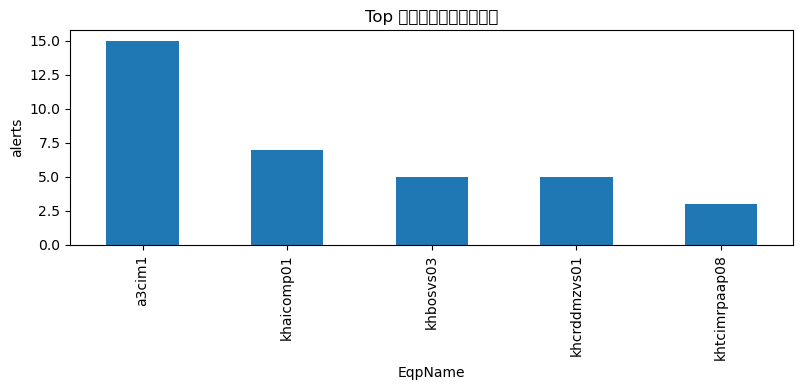

NameError: name 'dedup_counts' is not defined

<Figure size 800x400 with 0 Axes>

In [10]:
plt.figure()
top_noisy.head(10).plot(kind="bar")
plt.title("Top 噪音設備（總預警數）")
plt.ylabel("alerts")
plt.xlabel("EqpName")
plt.tight_layout()
plt.show()

plt.figure()
dedup_counts.head(10).plot(kind="bar")
plt.title("Top 噪音設備（冷卻 60 分去重）")
plt.ylabel("unique alerts")
plt.xlabel("EqpName")
plt.tight_layout()
plt.show()


In [11]:
# 高價值設備（依 F1）
ranked = per_eqp.head(10).reset_index(drop=True)
ranked


,TP,FP,FN,precision,recall,f1,mean_lead_min,EqpName,pred_cnt,label_cnt
0,9,6,3,0.600000,0.75,0.666667,17.333333,a3cim1,15,12
1,1,2,0,0.333333,1.00,0.500000,13.000000,khtcimrpaap08,3,1
2,1,4,0,0.200000,1.00,0.333333,24.000000,khbosvs03,5,1
3,1,4,0,0.200000,1.00,0.333333,14.000000,khcrddmzvs01,5,1
4,0,7,1,0.000000,0.00,0.000000,0.000000,khaicomp01,7,1


/var/folders/sr/l54kdb4j75b32dxgvj1v0p_m0000gn/T/ipykernel_18285/2761536678.py:6: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from current font.
  plt.tight_layout()
/var/folders/sr/l54kdb4j75b32dxgvj1v0p_m0000gn/T/ipykernel_18285/2761536678.py:6: UserWarning: Glyph 20729 (\N{CJK UNIFIED IDEOGRAPH-50F9}) missing from current font.
  plt.tight_layout()
/var/folders/sr/l54kdb4j75b32dxgvj1v0p_m0000gn/T/ipykernel_18285/2761536678.py:6: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  plt.tight_layout()
/var/folders/sr/l54kdb4j75b32dxgvj1v0p_m0000gn/T/ipykernel_18285/2761536678.py:6: UserWarning: Glyph 35373 (\N{CJK UNIFIED IDEOGRAPH-8A2D}) missing from current font.
  plt.tight_layout()
/var/folders/sr/l54kdb4j75b32dxgvj1v0p_m0000gn/T/ipykernel_18285/2761536678.py:6: UserWarning: Glyph 20633 (\N{CJK UNIFIED IDEOGRAPH-5099}) missing from current font.
  plt.tight_layout()
/var/folders/sr/l54kdb4j75b32dxgvj1v0p_m0000gn/T/ipykernel_1

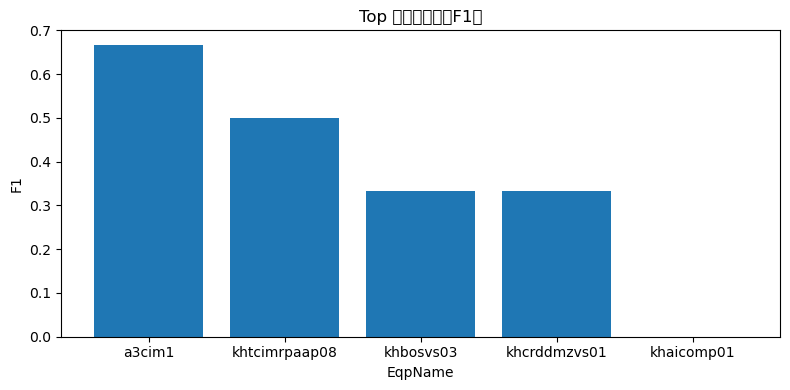

/var/folders/sr/l54kdb4j75b32dxgvj1v0p_m0000gn/T/ipykernel_18285/2761536678.py:14: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from current font.
  plt.tight_layout()
/var/folders/sr/l54kdb4j75b32dxgvj1v0p_m0000gn/T/ipykernel_18285/2761536678.py:14: UserWarning: Glyph 20729 (\N{CJK UNIFIED IDEOGRAPH-50F9}) missing from current font.
  plt.tight_layout()
/var/folders/sr/l54kdb4j75b32dxgvj1v0p_m0000gn/T/ipykernel_18285/2761536678.py:14: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  plt.tight_layout()
/var/folders/sr/l54kdb4j75b32dxgvj1v0p_m0000gn/T/ipykernel_18285/2761536678.py:14: UserWarning: Glyph 35373 (\N{CJK UNIFIED IDEOGRAPH-8A2D}) missing from current font.
  plt.tight_layout()
/var/folders/sr/l54kdb4j75b32dxgvj1v0p_m0000gn/T/ipykernel_18285/2761536678.py:14: UserWarning: Glyph 20633 (\N{CJK UNIFIED IDEOGRAPH-5099}) missing from current font.
  plt.tight_layout()
/var/folders/sr/l54kdb4j75b32dxgvj1v0p_m0000gn/T/ipyker

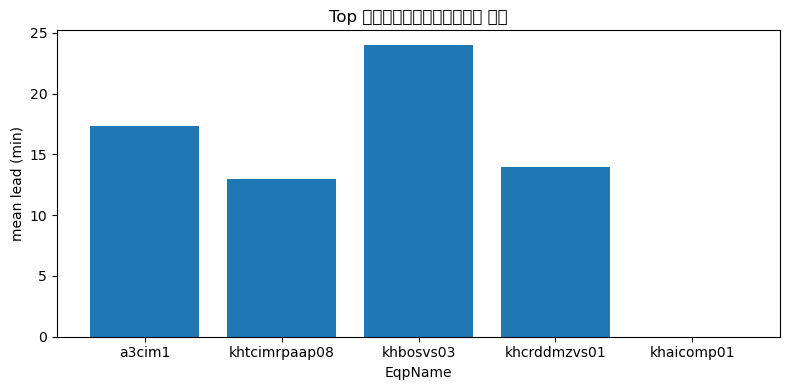

In [12]:
plt.figure()
plt.bar(ranked["EqpName"], ranked["f1"])
plt.title("Top 高價值設備（F1）")
plt.ylabel("F1")
plt.xlabel("EqpName")
plt.tight_layout()
plt.show()

plt.figure()
plt.bar(ranked["EqpName"], ranked["mean_lead_min"])
plt.title("Top 高價值設備（平均提前時間 分）")
plt.ylabel("mean lead (min)")
plt.xlabel("EqpName")
plt.tight_layout()
plt.show()


## 6) 一頁成效摘要（Word/Markdown）


In [13]:
from pathlib import Path
onepager_docx = Path("R1_eval_onepager.docx")
onepager_md   = Path("R1_eval_onepager.md")

period = f"{pred['t_pred'].min().tz_localize('UTC').tz_convert('Asia/Taipei'):%Y-%m-%d} ~ {pred['t_pred'].max().tz_localize('UTC').tz_convert('Asia/Taipei'):%Y-%m-%d}"
days = max((pred["t_pred"].max() - pred["t_pred"].min()).days + 1, 1)
alerts_total = len(pred)
alerts_per_day = round(alerts_total / days, 2)

ov = pd.read_csv("R1_eval_metrics_overall.csv").iloc[0].to_dict()
ov_line = (f"TP={int(ov.get('TP',0))}, FP={int(ov.get('FP',0))}, FN={int(ov.get('FN',0))}, "
           f"Precision={ov.get('precision',0):.3f}, Recall={ov.get('recall',0):.3f}, "
           f"F1={ov.get('f1',0):.3f}, 平均提前時間={ov.get('mean_lead_min',0):.1f} 分")

hot_summary = ", ".join([f"{int(r['hour']):02d}:{int(r['minute_bin']):02d} ({int(r['alerts'])})"
                         for _, r in hot_slots.iterrows()])
top_devices = ", ".join(list(top_noisy.head(5).index))

saved_docx = False
try:
    from docx import Document
    doc = Document()
    doc.add_heading("主機異常預警 — 一頁成效摘要", level=0)
    doc.add_paragraph(f"評估期間：{period}（台北時間）")
    doc.add_paragraph(f"整體指標：{ov_line}")
    doc.add_paragraph(f"總預警數：{alerts_total}（平均 {alerts_per_day}/天）")

    doc.add_heading("關鍵觀察", level=1)
    doc.add_paragraph(f"• 時間熱點：{hot_summary if hot_summary else '無顯著熱點'}")
    doc.add_paragraph(f"• 噪音設備 Top：{top_devices if top_devices else '無'}")
    doc.add_paragraph(f"• 高價值設備 Top（F1）：{', '.join(list(ranked['EqpName'])[:5]) if not ranked.empty else '無'}")

    doc.add_heading("建議下一步", level=1)
    doc.add_paragraph("1) 對熱點時段（如 00:15）對表備份/AV/批次排程，必要時加白名單或提高門檻。")
    doc.add_paragraph("2) 噪音設備採用「連續 k 視窗成立 + 冷卻 60 分」以降噪。")
    doc.add_paragraph("3) 對盲區設備加入 R2 關鍵字前兆或更換設備欄位（EqpName→Host）。")

    doc.save(onepager_docx); saved_docx = True
    print("已輸出 Word：", onepager_docx)
except Exception as e:
    print("DOCX 失敗，改輸出 Markdown：", e)

if not saved_docx:
    with open(onepager_md, "w", encoding="utf-8") as f:
        f.write("# 主機異常預警 — 一頁成效摘要\n\n")
        f.write(f"- 評估期間：{period}（台北時間）\n")
        f.write(f"- 整體指標：{ov_line}\n")
        f.write(f"- 總預警數：{alerts_total}（平均 {alerts_per_day}/天）\n\n")
        f.write("## 關鍵觀察\n")
        f.write(f"- 時間熱點：{hot_summary if hot_summary else '無顯著熱點'}\n")
        f.write(f"- 噪音設備 Top：{top_devices if top_devices else '無'}\n")
        if not ranked.empty:
            f.write(f"- 高價值設備 Top（F1）：{', '.join(list(ranked['EqpName'])[:5])}\n")
        else:
            f.write("- 高價值設備 Top（F1）：無\n")
        f.write("\n## 建議下一步\n")
        f.write("1) 對熱點時段（如 00:15）對表備份/AV/批次排程，必要時加白名單或提高門檻。\n")
        f.write("2) 噪音設備採用「連續 k 視窗成立 + 冷卻 60 分」以降噪。\n")
        f.write("3) 對盲區設備加入 R2 關鍵字前兆或更換設備欄位（EqpName→Host）。\n")
    print("已輸出 Markdown：", onepager_md)


TypeError: Cannot localize tz-aware Timestamp, use tz_convert for conversions

## 7) 面試用口頭報告重點


In [14]:
print("""
【專案定位】主機異常預警（兩個月 POC）。以 ELK Logs 找「可提前量」的前兆訊號。
【方法】R1：15m 內 S2='SOFT' 次數 > 3；Label：Status='red'；時間型匹配（t_pred ≤ t_event ≤ t_pred+ϑ）。
【指標】Precision / Recall / F1 / 平均提前時間；另做 per-Eqp，支持降噪與白名單策略。
【輸出】四個 CSV + 三張圖 + 一頁成效摘要（Word/Markdown）。
【改善】連續視窗成立、冷卻 60 分、關鍵字 R2、1 分鐘滑動視窗、欄位對齊（EqpName/Host）。
【上線】批次排程 + Email 通知 + 告警紀錄；週週重跑指標，兩個月內把 Precision/Recall 與提前量拉升。
""")



【專案定位】主機異常預警（兩個月 POC）。以 ELK Logs 找「可提前量」的前兆訊號。
【方法】R1：15m 內 S2='SOFT' 次數 > 3；Label：Status='red'；時間型匹配（t_pred ≤ t_event ≤ t_pred+ϑ）。
【指標】Precision / Recall / F1 / 平均提前時間；另做 per-Eqp，支持降噪與白名單策略。
【輸出】四個 CSV + 三張圖 + 一頁成效摘要（Word/Markdown）。
【改善】連續視窗成立、冷卻 60 分、關鍵字 R2、1 分鐘滑動視窗、欄位對齊（EqpName/Host）。
【上線】批次排程 + Email 通知 + 告警紀錄；週週重跑指標，兩個月內把 Precision/Recall 與提前量拉升。

